# Indoor Scenes Classification

**Background:**  
Even though many scene detection AIs are able to detect the outdoor scene accurately, those AIs fail to detect indoor scenes. The key challenge of classifying indoor scenes is that the algorithm needs to be able to use partial scene features (ex. objects) to accurately identify the scene while general scene detection algorithms focus on using global spatial properties. 

**Potential Implementation:**   
If a user intends to search for an image of an indoor scene (Ex. coffee shops) on the internet, a normal approach will be comparing the image with millions of images in the dataset and find the most similar ones and then feed the user the results. While all the indoor scene images in the database can be pre-classified into different categories of scenes (Ex. Libraries, restaurants, etc.), the search engine will then be able to firstly detect the scene of the user-uploaded image, and then compare the image with all images that belong to the detected scene rather than all images in the database. If the scene of the uploaded image is accurately categorized, it would save enormous computational resources, reduce search time, and increase the accuracy of the result. 

## 1. SOURCE

### 1.1 Used Dataset

>Indoor Scene Recognition.([This Link](https://www.???))
>- The database contains 67 Indoor categories and a total of 15620 images. The number of images varies across categories, but there are at least 100 images per category. .
>- Data Provided by: Thanks to Aude Oliva for helping to create the database of indoor scenes. Funding for this research was provided by NSF Career award (IIS 0747120).

### 1.2 Import Libraries

In [ ]:
# Importing required libraries
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
np.random.seed(42)
import random as rn
rn.seed(42)
import tensorflow as tf
tf.random.set_seed(42)
import pandas as pd
import PIL
from PIL import Image
import pathlib
import math
import zipfile
import os
import urllib
from google.colab.patches import cv2_imshow 
import cv2
import glob
import tensorflow as tf

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, Dense, Flatten, GlobalMaxPool3D, BatchNormalization, Dropout, Activation
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import layers
from keras import optimizers
from keras.regularizers import l2
from keras.models import load_model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import Conv2D , MaxPool2D , Flatten
from keras.layers.normalization.batch_normalization_v1 import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
# Importing required libraries
import os
import pathlib
import math
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow 
import numpy as np
np.random.seed(42)
import random as rn
rn.seed(42)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(42)
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, Dense, Flatten, GlobalMaxPool3D, BatchNormalization, Dropout, Activation
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2
from keras.models import load_model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.inception_resnet_v2 import InceptionResNetV2

### 1.3 Import Dataset

In [ ]:
!wget --no-check-certificate \
    "https://github.com/LinhTo11/Capstone" \
    -O "/tmp/image.zip"


zip_ref = zipfile.ZipFile('/tmp/image.zip', 'r') 
zip_ref.extractall('/tmp')
zip_ref.close()

--2022-03-18 00:19:25--  https://github.com/KaiyuWang19970221/BA865/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/KaiyuWang19970221/BA865/zip/refs/heads/main [following]
--2022-03-18 00:19:25--  https://codeload.github.com/KaiyuWang19970221/BA865/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.121.9
Connecting to codeload.github.com (codeload.github.com)|140.82.121.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/image.zip’

/tmp/image.zip          [ <=>                ]   2.28G  20.1MB/s    in 1m 57s  

2022-03-18 00:21:23 (19.9 MB/s) - ‘/tmp/image.zip’ saved [2452993858]



In [ ]:
# check how many labels
dataset = '/tmp/BA865-main/Images'
print(len(os.listdir(dataset)))

67


## 2. Simple Model 1 (19.00%)

### 2.1 Split dataset

In [ ]:
datagen=keras.preprocessing.image.ImageDataGenerator(rescale=1./255, zoom_range=0.2, horizontal_flip=True)

>Preprocess strategies:
>- Rescale : Our image are already in a standard size (180x180), as they are being yielded as contiguous float32 batches by our dataset. However, their RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Therefore we preprocess our images by using 1.0/255 to rescale, so that we could standardize values to be close to the [0, 1] 
>- Horizontal_ flip : We could artifically introduce diversity into our dataset by using horizontal flipping. This helps expose the model to different aspects of the training data while slowing down overfitting.
>- Zoom : Since indoor sence pictures normally look very similar in general, we added zoom in as part of our pre-process, this way we could get more detials about the sense. This way we could improve our accuracy. 

In [ ]:
train_data = datagen.flow_from_directory(
        directory=r'/tmp/BA865-main/Images2/train',
        target_size=(180, 180),
        batch_size=32,
        class_mode="categorical")

Found 10640 images belonging to 67 classes.


In [ ]:
test_data = datagen.flow_from_directory(
    directory=r"/tmp/BA865-main/Images2/test",
    target_size=(180, 180),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical"
)

Found 1584 images belonging to 67 classes.


In [ ]:
valid_data = datagen.flow_from_directory(
    directory=r"/tmp/BA865-main/Images2/val",
    target_size=(180, 180),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical"
)

Found 3027 images belonging to 67 classes.


### 2.2 Bulid model

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
#Adding sequential model in keras
model = Sequential()
# Image size 64*64 
model.add(Conv2D(32, (3, 3), input_shape=(180, 180, 3)))
#ReLu adds nonlinearity to the network.
model.add(Activation('relu'))
# Pooling helps to reduce dimensions.
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#Fully connected layer to detect final high level features.
model.add(Flatten())  
model.add(Dense(64))
model.add(Activation('relu'))
#Dropout is added to reduce overfitting.
model.add(Dropout(0.5))

model.add(Dense(67))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 activation (Activation)     (None, 178, 178, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 87, 87, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                    

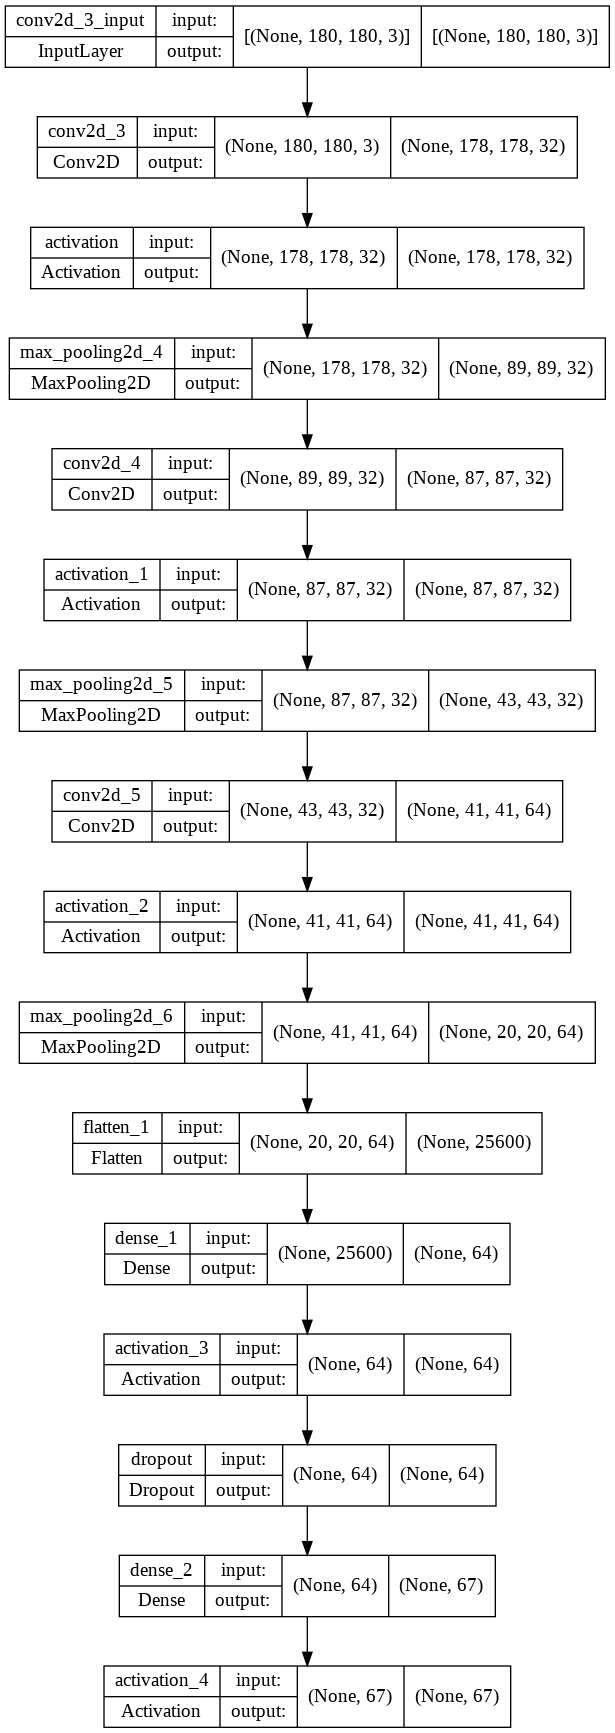

In [ ]:
from keras.utils.vis_utils import plot_model
keras.utils.vis_utils.plot_model(model, show_shapes=True)

In [ ]:
# import tensorflow as tf
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.compat.v1.Session(config=config)

In [ ]:
history=model.fit_generator(
        train_data,
        epochs=10,
        validation_data=valid_data
        )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/10
333/333 [==============================] - 161s 478ms/step - loss: 4.0812 - accuracy: 0.0459 - val_loss: 3.9365 - val_accuracy: 0.0925
Epoch 2/10
333/333 [==============================] - 159s 477ms/step - loss: 3.9180 - accuracy: 0.0720 - val_loss: 3.7306 - val_accuracy: 0.1130
Epoch 3/10
333/333 [==============================] - 158s 476ms/step - loss: 3.7986 - accuracy: 0.0888 - val_loss: 3.6818 - val_accuracy: 0.1179
Epoch 4/10
333/333 [==============================] - 159s 477ms/step - loss: 3.7094 - accuracy: 0.0983 - val_loss: 3.4952 - val_accuracy: 0.1592
Epoch 5/10
333/333 [==============================] - 158s 476ms/step - loss: 3.6378 - accuracy: 0.1123 - val_loss: 3.4625 - val_accuracy: 0.1625
Epoch 6/10
333/333 [==============================] - 158s 476ms/step - loss: 3.5704 - accuracy: 0.1262 - val_loss: 3.3609 - val_accuracy: 0.1715
Epoch 7/10
333/333 [==============================] - 159s 477ms/step - loss: 3.5295 - accuracy: 0.1246 - val_loss: 3.3451 -

### 2.3 Model evaluation

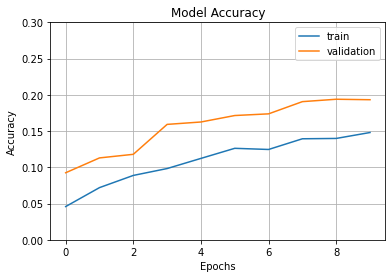

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0,ymax=0.3)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
accuracy = model.evaluate(test_data,batch_size=32)

50/50 [==============================] - 19s 369ms/step - loss: 3.3254 - accuracy: 0.1900


## 3. Simple Model 2 with data augmentation (19.32%)

### 3.1 Split image folders into training,val and test

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders

In [ ]:
input_folder='/tmp/BA865-main/Images'
splitfolders.ratio(input_folder,output='/tmp/BA865-main/Images2',
                   seed=865, ratio=(.7,.2,.1),
                   group_prefix=None
)

Copying files: 15282 files [00:07, 1970.59 files/s]


### 3.2 Creating traning,val and test dataset

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

In [ ]:
#We noticed that when using image_dataset_from directory, some of the images couldn't be read for some unknown reason
#Thus, we used thus block of code to find those images that couldn't be read
folders = ['/train/','/test/','/val/']
basePath = '/tmp/BA865-main/Images2'
corrupted = []
for folder in folders:
  #count the number of corrupted files in different folders
  n=0
  for classname in os.listdir(basePath + folder):
    for filename in os.listdir(basePath + folder + classname):
      try: 
        #Try using cv2 and tfio.read_file to double check if the image is readable
        img = cv2.imread(basePath + folder + classname + '/' + filename)
        dimensions = img.shape
        img_bytes = tf.io.read_file(basePath + folder + classname + '/' + filename)
        decoded_img = tf.io.decode_image(img_bytes)
      except:
        corrupted.append(basePath + folder + classname + '/' + filename)
        n+=1
  print('{num} corrupted files were found in folder: {folder}'.format(num=n,folder = folder))

26 corrupted files were found in folder: /train/
1 corrupted files were found in folder: /test/
4 corrupted files were found in folder: /val/


In [ ]:
#remove the corrupted files 
import shutil
for path in corrupted:
  os.remove(path)

In [ ]:
train_dataset = image_dataset_from_directory(
    directory=r'/tmp/BA865-main/Images2/train',
    labels="inferred",
    #marked label as categorical otherwise for one-hoe encoding
    label_mode="categorical",
    image_size=(180,180)
    )

Found 10640 files belonging to 67 classes.


In [ ]:
test_dataset = image_dataset_from_directory(
    directory=r'/tmp/BA865-main/Images2/test',
    #labels="inferred",
    #marked label as categorical otherwise for one-hoe encoding
    label_mode="categorical",
    image_size=(180,180)
    )

Found 1584 files belonging to 67 classes.


In [ ]:
valid_dataset = image_dataset_from_directory(
    directory=r'/tmp/BA865-main/Images2/val',
    labels="inferred",
    #marked label as categorical otherwise for one-hoe encoding
    label_mode="categorical",
    image_size=(180,180)
    )

Found 3027 files belonging to 67 classes.


### 3.3 Build our own models

In [ ]:
input= keras.Input(shape=(180, 180, 3))
x = BatchNormalization()(input)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
#noticed overfitting
output = layers.Dense(67, activation="softmax")(x)
model = keras.Model(input, output)

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=["accuracy"])

history = model.fit(train_dataset,
                    epochs=10, 
                    batch_size=25,
                    validation_data=valid_dataset
                    )

Epoch 1/10
333/333 [==============================] - 29s 55ms/step - loss: 6.3611 - accuracy: 0.0990 - val_loss: 6.5543 - val_accuracy: 0.0737
Epoch 2/10
333/333 [==============================] - 18s 54ms/step - loss: 3.8625 - accuracy: 0.2329 - val_loss: 4.8518 - val_accuracy: 0.1361
Epoch 3/10
333/333 [==============================] - 18s 54ms/step - loss: 2.2915 - accuracy: 0.4261 - val_loss: 4.5335 - val_accuracy: 0.1632
Epoch 4/10
333/333 [==============================] - 18s 54ms/step - loss: 1.2793 - accuracy: 0.6356 - val_loss: 4.7741 - val_accuracy: 0.1682
Epoch 5/10
333/333 [==============================] - 18s 54ms/step - loss: 0.6779 - accuracy: 0.7968 - val_loss: 5.0568 - val_accuracy: 0.1724
Epoch 6/10
333/333 [==============================] - 19s 55ms/step - loss: 0.3714 - accuracy: 0.8873 - val_loss: 5.5351 - val_accuracy: 0.1860
Epoch 7/10
333/333 [==============================] - 19s 55ms/step - loss: 0.2381 - accuracy: 0.9263 - val_loss: 5.8704 - val_accuracy:

### 3.4 Model evaluation

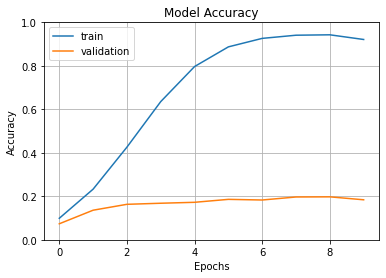

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
accuracy = model.evaluate(test_dataset,batch_size=32)

50/50 [==============================] - 2s 36ms/step - loss: 7.5632 - accuracy: 0.1932


## 4. Self-made Model+InceptionV3 (79.49%)

### 4.1 Import smaller dataset

In [ ]:
!wget --no-check-certificate \
    "https://github.com/KaiyuWang19970221/BA865_2/archive/refs/heads/main.zip" \
    -O "/content/image_small.zip"


zip_ref = zipfile.ZipFile('/content/image_small.zip', 'r') 
zip_ref.extractall('/content')
zip_ref.close()

--2022-03-18 00:54:35--  https://github.com/KaiyuWang19970221/BA865_2/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/KaiyuWang19970221/BA865_2/zip/refs/heads/main [following]
--2022-03-18 00:54:35--  https://codeload.github.com/KaiyuWang19970221/BA865_2/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.121.9
Connecting to codeload.github.com (codeload.github.com)|140.82.121.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/content/image_small.zip’

/content/image_smal     [<=>                 ] 575.55M  20.4MB/s    in 30s     

2022-03-18 00:55:05 (19.5 MB/s) - ‘/content/image_small.zip’ saved [603505307]



### 4.2 Split dataset

In [ ]:
# Training dataset
data_path= '/content/BA865_2-main/image/'
train_data_dir= pathlib.Path(data_path)
image_count= len(list(train_data_dir.glob('*/*.jpg')))
print(image_count)

# Setting image height, width and batch size
img_height= 150
img_width= 150
batch_size= 64

3315


In [ ]:
# Training dataset
train_ds= tf.keras.preprocessing.image_dataset_from_directory(train_data_dir, seed= 42, validation_split= 0.2,
                                                              subset= 'training',
                                                              batch_size= batch_size,
                                                              image_size= (img_height, img_width)
                                                              )

Found 3315 files belonging to 10 classes.
Using 2652 files for training.


In [ ]:
val_ds= tf.keras.preprocessing.image_dataset_from_directory(train_data_dir, seed= 42, validation_split= 0.2,
                                                              subset= 'validation',
                                                              batch_size= batch_size,
                                                              image_size= (img_height, img_width)
                                                              )

Found 3315 files belonging to 10 classes.
Using 663 files for validation.


### 4.3 Implement inceptionV3 finetuning

In [ ]:
# ## Creating data augmentation layer
augmentation_layer= Sequential(
  [tf.keras.layers.InputLayer(input_shape= (img_height, img_width, 3)),
   tf.keras.layers.RandomFlip('horizontal', seed= 42),
   tf.keras.layers.RandomRotation(0.2, fill_mode= 'wrap', seed= 42),
   tf.keras.layers.RandomZoom(0.2, seed= 42),
   tf.keras.layers.RandomTranslation(.2, .2, fill_mode='wrap', interpolation='bilinear', seed= 42),
   tf.keras.layers.RandomContrast(0.2, seed= 42)]
   )

In [ ]:
# Function to fine tune InceptionV3
def inceptionv3(inp_shape, dropout_rate, train_layers_after):
    inceptionv3= InceptionV3(weights= 'imagenet', include_top= False)
    for layer in inceptionv3.layers[:train_layers_after]:
      layer.trainable= False
    input_layer= Input(shape= inp_shape)
    data_aug_layer= augmentation_layer(input_layer)
    norm_layer= tf.keras.layers.Rescaling(1./255)(data_aug_layer)
    cnn_layers= inceptionv3(norm_layer)
    flatten_layer= Flatten()(cnn_layers)
    dropout_layer1= Dropout(dropout_rate)(flatten_layer)
    dense_layer= Dense(1024, activation= 'relu', kernel_initializer= 'he_normal', kernel_regularizer='l2')(dropout_layer1)
    dropout_layer2= Dropout(dropout_rate)(dense_layer)
    dense_layer_1= Dense(512, activation= 'relu', kernel_initializer= 'he_normal', kernel_regularizer='l2')(dropout_layer2)
    dropout_layer3= Dropout(dropout_rate)(dense_layer_1)
    output_layer= Dense(10, activation= 'softmax')(dropout_layer3)
    model= Model(input_layer, output_layer)
    model.compile(optimizer= 'adam', loss= 'sparse_categorical_crossentropy', metrics= ['sparse_categorical_accuracy'])
    return model

In [ ]:
# Creating model
inp_shape= (150, 150, 3)
dropout_rate= .25
train_layers_after= 249
incv3_model= inceptionv3(inp_shape, dropout_rate, train_layers_after)
incv3_model.summary()

87924736/87910968 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 flatten_2 (Flatten)         (None, 18432)             0         
                                                                 
 dropout_1 (Dropout)         (None, 18432)             0         
                                                            

In [ ]:
# Loading data into cache to overcome data bottleneck during training.
AUTOTUNE= tf.data.AUTOTUNE
AUTOTUNE= tf.data.experimental.AUTOTUNE

# Shuffling data before starting of each epoch
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size= AUTOTUNE)
val_ds= val_ds.cache().prefetch(buffer_size= AUTOTUNE)

In [ ]:
# Setting callbacks

base_path= '/content/BA865_2-main/models/'

filepath= base_path + 'model-{epoch:05d}-{loss:.5f}-{sparse_categorical_accuracy:.5f}-{val_loss:.5f}-{val_sparse_categorical_accuracy:.5f}.h5'

checkpoint= ModelCheckpoint(filepath, monitor= 'val_sparse_categorical_accuracy', verbose= 1, 
                            save_best_only= True, save_weights_only= False, mode= 'auto')

LR= ReduceLROnPlateau(monitor= 'val_loss', factor= 0.1, patience= 30, verbose= 1)
callbacks_list= [checkpoint, LR]

### 4.4 Model evaluation

In [ ]:
# Model training
epochs= 20
steps_per_epoch= math.ceil(2652/batch_size)
validation_steps= math.ceil(663/batch_size)

history= incv3_model.fit(train_ds, validation_data= val_ds, steps_per_epoch= steps_per_epoch, epochs= epochs, callbacks= callbacks_list, validation_steps= validation_steps)

Epoch 1/20
42/42 [==============================] - ETA: 0s - loss: 25.5347 - sparse_categorical_accuracy: 0.3842
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.55505, saving model to /content/BA865_2-main/models/model-00001-25.53466-0.38424-19.90107-0.55505.h5
42/42 [==============================] - 16s 160ms/step - loss: 25.5347 - sparse_categorical_accuracy: 0.3842 - val_loss: 19.9011 - val_sparse_categorical_accuracy: 0.5551 - lr: 0.0010
Epoch 2/20
42/42 [==============================] - ETA: 0s - loss: 10.5726 - sparse_categorical_accuracy: 0.6467
Epoch 2: val_sparse_categorical_accuracy improved from 0.55505 to 0.68175, saving model to /content/BA865_2-main/models/model-00002-10.57263-0.64668-8.52518-0.68175.h5
42/42 [==============================] - 4s 94ms/step - loss: 10.5726 - sparse_categorical_accuracy: 0.6467 - val_loss: 8.5252 - val_sparse_categorical_accuracy: 0.6817 - lr: 0.0010
Epoch 3/20
42/42 [==============================] - ETA: 0s - loss: 5.6

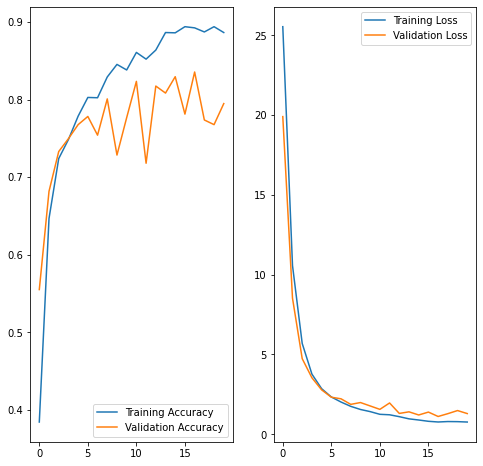

In [ ]:
acc= history.history['sparse_categorical_accuracy']
val_acc= history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

Depends on the running result：
- Best Epoch: 16 
- **Training: loss: .08 - categorical_accuracy: 0.89**
- **Validation: val_loss: .68 - val_sparse_categorical_accuracy: 0.7949**

## 5. Pytorch Model(DensenNet) (70.80%)

### 5.1 Transform image

In [ ]:
dataset = '/tmp/BA865-main/Images'

In [ ]:
# Specify transforms using torchvision.transforms as transforms
# library
transformations = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
#    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
from torchvision.datasets import ImageFolder
df = ImageFolder(dataset, transform = transformations)

### 5.2 Vislization

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
def show_sample(img, label):
    print("Label:", df.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))
img, label = df[0]
show_sample(img, label)

In [ ]:
df.classes[0]

In [ ]:
len(df)

### 5.3 Split dataset

In [ ]:
from torch.utils.data import random_split
train_set, test_set = random_split(df, [12000, 3282])
len(train_set), len(test_set)

In [ ]:
# Put into a Dataloader using torch library
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size =32, shuffle=True)

### 5.4 Import pytorch pre-trained model

In [ ]:
# Get pretrained model using torchvision.models as models library
model = models.densenet161(pretrained=True)
# Turn off training for their parameters
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# Create new classifier for model using torch.nn as nn library
classifier_input = model.classifier.in_features
num_labels = 67
classifier = nn.Sequential(nn.Linear(classifier_input, 1024),
                           nn.ReLU(),
                           nn.Linear(1024, 512),
                           nn.ReLU(),
                           nn.Linear(512, num_labels),
                           nn.LogSoftmax(dim=1))
# Replace default classifier with new classifier
model.classifier = classifier

In [ ]:
# Find the device available to use using torch library
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move model to the device specified above
model.to(device)

In [ ]:
# Set the error function using torch.nn as nn library
criterion = nn.NLLLoss()
# Set the optimizer function using torch.optim as optim library
optimizer = optim.Adam(model.classifier.parameters())

### 5.5 Model evaluation

In [ ]:
epochs = 10
for epoch in range(epochs):
    train_loss = 0
    val_loss = 0
    accuracy = 0
    
    # Training the model
    model.train()
    counter = 0
    for inputs, labels in train_loader:
        # Move to device
        inputs, labels = inputs.to(device), labels.to(device)
        # Clear optimizers
        optimizer.zero_grad()
        # Forward pass
        output = model.forward(inputs)
        # Loss
        loss = criterion(output, labels)
        # Calculate gradients (backpropogation)
        loss.backward()
        # Adjust parameters based on gradients
        optimizer.step()
        # Add the loss to the training set's rnning loss
        train_loss += loss.item()*inputs.size(0)
        
        # Print the progress of our training
        counter += 1
        print(counter, "/", len(train_loader))
        
    # Evaluating the model
    model.eval()
    counter = 0
    # Tell torch not to calculate gradients
    with torch.no_grad():
        for inputs, labels in test_loader:
            # Move to device
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            output = model.forward(inputs)
            # Calculate Loss
            valloss = criterion(output, labels)
            # Add loss to the validation set's running loss
            val_loss += valloss.item()*inputs.size(0)
            
            # Since our model outputs a LogSoftmax, find the real 
            # percentages by reversing the log function
            output = torch.exp(output)
            # Get the top class of the output
            top_p, top_class = output.topk(1, dim=1)
            # See how many of the classes were correct?
            equals = top_class == labels.view(*top_class.shape)
            # Calculate the mean (get the accuracy for this batch)
            # and add it to the running accuracy for this epoch
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            # Print the progress of our evaluation
            counter += 1
            print(counter, "/", len(test_loader))
    
    # Get the average loss for the entire epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = val_loss/len(test_loader.dataset)
    # Print out the information
    print('Accuracy: ', accuracy/len(test_loader))
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))

**Best Performance**:  
Accuracy:70.8%   
Training loss: 0.468517  
Validation Loss: 1.165374

### 5.6 Preprocess for prediction

In [ ]:
# Process our image
def process_image(image_path):
    # Load Image
    img = Image.open(image_path)
    
    # Get the dimensions of the image
    width, height = img.size
    
    # Resize by keeping the aspect ratio, but changing the dimension
    # so the shortest size is 255px
    img = img.resize((255, int(255*(height/width))) if width < height else (int(255*(width/height)), 255))
    
    # Get the dimensions of the new image size
    width, height = img.size
    
    # Set the coordinates to do a center crop of 224 x 224
    left = (width - 224)/2
    top = (height - 224)/2
    right = (width + 224)/2
    bottom = (height + 224)/2
    img = img.crop((left, top, right, bottom))
    
    # Turn image into numpy array
    img = np.array(img)
    
    # Make the color channel dimension first instead of last
    img = img.transpose((2, 0, 1))
    
    # Make all values between 0 and 1
    img = img/255
    
    # Normalize based on the preset mean and standard deviation
    img[0] = (img[0] - 0.485)/0.229
    img[1] = (img[1] - 0.456)/0.224
    img[2] = (img[2] - 0.406)/0.225
    
    # Add a fourth dimension to the beginning to indicate batch size
    img = img[np.newaxis,:]
    
    # Turn into a torch tensor
    image = torch.from_numpy(img)
    image = image.float()
    return image

In [ ]:
# Using our model to predict the label
def predict(image, model):
    # Pass the image through our model
    output = model.forward(image)
    
    # Reverse the log function in our output
    output = torch.exp(output)
    
    # Get the top predicted class, and the output percentage for
    # that class
    probs, classes = output.topk(1, dim=1)
    return probs.item(), classes.item()

In [ ]:
# Show Image
def show_image(image):
    # Convert image to numpy
    image = image.numpy()
    
    # Un-normalize the image
    image[0] = image[0] * 0.226 + 0.445
    
    # Print the image
    fig = plt.figure(figsize=(25, 4))
    plt.imshow(np.transpose(image[0], (1, 2, 0)))

### 5.7 Prediction

In [ ]:
# Process Image
image = process_image("/tmp/BA865-main/Images/bar/bar_0001.jpg")
image=image.cuda()
# Give image to model to predict output
top_prob, top_class = predict(image, model)
# Show the image
image = image.cpu()
show_image(image)
# Print the results
print("The model is ", top_prob*100, "% certain that the image has a predicted class of ", top_class  )

In [ ]:
df.classes[4]

In [ ]:
# Process Image
image = process_image("/tmp/BA865-main/Images/buffet/060926buffet_560.jpg")
image=image.cuda()
# Give image to model to predict output
top_prob, top_class = predict(image, model)
# Show the image
image = image.cpu()
show_image(image)
# Print the results
print("The model is ", top_prob*100, "% certain that the image has a predicted class of ", top_class  )

In [ ]:
df.classes[9]

## 6. Benchmark

### 

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# import keras
# from keras.models import Sequential
# from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
# from keras.preprocessing.image import ImageDataGenerator

# from sklearn.metrics import classification_report,confusion_matrix

# import tensorflow as tf

# import cv2
# import os

# import numpy as np

In [ ]:
# classes = os.listdir(dataset)

In [ ]:
# labels = classes
# img_size = 180
# def get_data(data_dir):
#     data = [] 
#     for label in labels: 
#         path = os.path.join(data_dir, label)
#         class_num = labels.index(label)
#         for img in os.listdir(path):
#             try:
#                 img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
#                 resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
#                 data.append([resized_arr, class_num])
#             except Exception as e:
#                 print(e)

In [ ]:
# train = get_data('/tmp/BA865-main/Images2/train')
# val = get_data('/tmp/BA865-main/Images2/val')

In [ ]:
# train = [x for x in train if x != None]

In [ ]:
# x_train = []
# y_train = []
# x_val = []
# y_val = []

# for feature, label in train:
#   x_train.append(feature)
#   y_train.append(label)

# for feature, label in val:
#   x_val.append(feature)
#   y_val.append(label)

# # Normalize the data
# x_train = np.array(x_train) / 255
# x_val = np.array(x_val) / 255

# x_train.reshape(-1, img_size, img_size, 1)
# y_train = np.array(y_train)

# x_val.reshape(-1, img_size, img_size, 1)
# y_val = np.array(y_val)

In [ ]:
# model=RandomForestClassifier()

In [ ]:
# model.fit(x_train,y_train)

## 7. Conclusion

**Things we learned in this project:**

1.How to split the whole folder into train, test, and validation dataset

2.How to move model parameters from CPU to GPU (In order for all operands of an operation to be on the same device

3.How to standardize the pre-process parameters for all models for better comparison

**Improvement to be made in the future：**

1.Learn how to pre-processing for the large dataset with reduced RAM consumption

2.In RAM’s precondition, build better layers to handle more class categories

3.Improve the parameters of single layer to run more layers with a certain amount of memory
